# Test and results.

In [1]:
from Markovify.Markovify import Markovify
from Markovify.Utils.CrossValidation import cross_validation_score

from nltk.corpus import brown

import pandas as pd
import numpy as np
import random
from math import ceil
import importlib

from Markovify.Utils.ProgressBar import log_progress

# Accuracy for news text.

In [2]:
corpus = brown.tagged_sents(categories='news', tagset='universal')

model = Markovify(smoothing='laplace', alpha=1)
brown_news_accuracy = cross_validation_score(model, sentences=corpus, cv=10, verbose=False)
print(brown_news_accuracy)
print('Best accuracy: {}.'.format(np.max(brown_news_accuracy)))

[0.92424664 0.92019022 0.89462453 0.90325306 0.9142     0.9090001
 0.89937782 0.92089762 0.91189633 0.9120901 ]
Best accuracy: 0.9242466388502549.


In [3]:
sample_idx = random.sample(range(0, len(corpus)), ceil(len(corpus) * 0.2))
sample_corpus = list(corpus[i] for i in sample_idx)

nfolds = [3, 5, 10]
scores = []
for n in log_progress(nfolds):
    model = Markovify(smoothing='laplace', alpha=1)
    score = cross_validation_score(model, sentences=sample_corpus, cv=n, verbose=False)
    scores.append(np.max(score))
    
print(scores)

[0.8620283018867925, 0.875, 0.8821989528795812]


# Comparison of different alphas.

In [6]:
corpus = brown.tagged_sents(categories='news', tagset='universal')

model07 = Markovify(smoothing='laplace', alpha=0.7)
brown_news_accuracy_0_7 = cross_validation_score(model07, sentences=corpus, verbose=False)
print('Best accuracy for alpha=0.7: {}.'.format(np.max(brown_news_accuracy_0_7)))

model03 = Markovify(smoothing='laplace', alpha=0.3)
brown_news_accuracy_0_3 = cross_validation_score(model03, sentences=corpus, verbose=False)
print('Best accuracy for alpha=0.3: {}.'.format(np.max(brown_news_accuracy_0_3)))

Best accuracy for alpha=0.7: 0.9166585198944178.
Best accuracy for alpha=0.3: 0.917196206862841.


# Accuracy for news text training the model using an adventures book.

In [7]:
corpus_advs = brown.tagged_sents(categories='adventure', tagset='universal')
corpus_news = brown.tagged_sents(categories='news', tagset='universal')

model = Markovify(smoothing='laplace', alpha=1)
model = model.fit(corpus_news)

tagged = model.predict(corpus_advs)

In [8]:
advs_records = [item for sublist in corpus_advs for item in sublist]
predicted_tags = [item for sublist in tagged for item in sublist]

results = pd.DataFrame.from_records(advs_records)
results.columns = ["Word", "Tag"]
results['Predicted'] = predicted_tags
results.head(10)

,Word,Tag,Predicted
0,Dan,NOUN,NOUN
1,Morgan,NOUN,NOUN
2,told,VERB,VERB
3,himself,PRON,PRON
4,he,PRON,PRON
5,would,VERB,VERB
6,forget,VERB,VERB
7,Ann,NOUN,NOUN
8,Turner,NOUN,NOUN
9,.,.,.


In [10]:
from Markovify.Utils.Scoring import *

cm = confusion_matrix(corpus_advs, tagged, as_df=True)

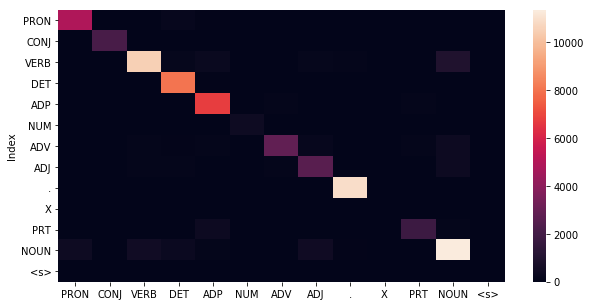

In [11]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sn
plt.rcParams['figure.figsize'] = [10, 5]

sn.heatmap(cm)